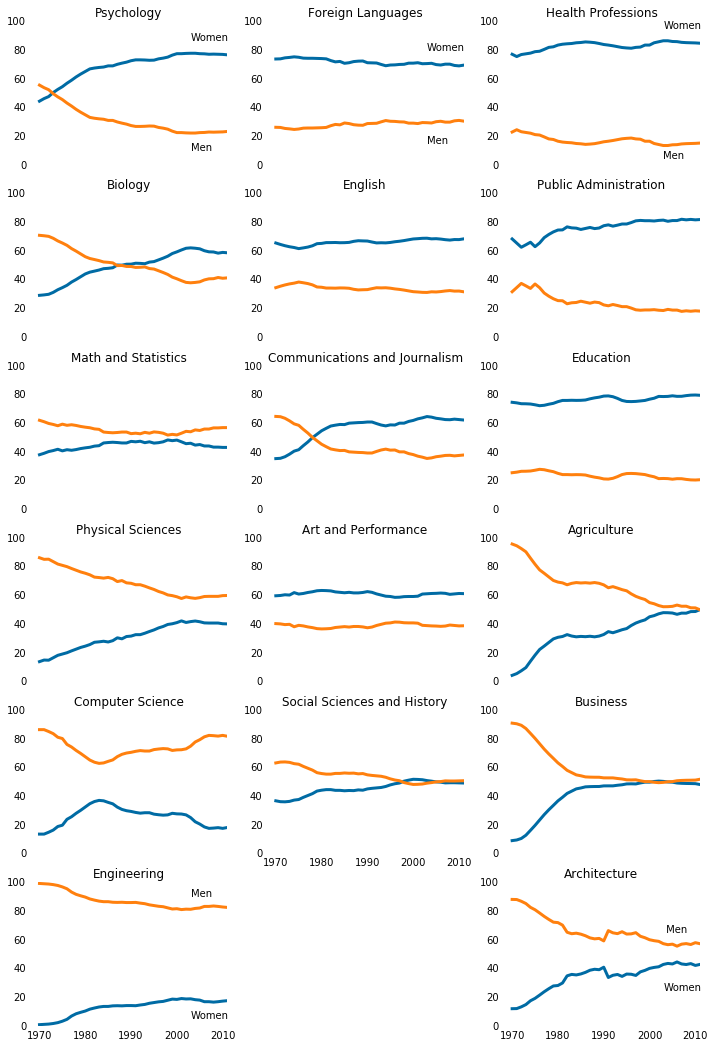

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

women_degrees = pd.read_csv('percent-bachelors-degrees-women-usa.csv')
cb_dark_blue = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)

stem_cats = ['Psychology', 'Biology', 'Math and Statistics', 'Physical Sciences', 'Computer Science', 'Engineering']
lib_arts_cats = ['Foreign Languages', 'English', 'Communications and Journalism', 'Art and Performance', 'Social Sciences and History']
other_cats = ['Health Professions', 'Public Administration', 'Education', 'Agriculture','Business', 'Architecture']

fig = plt.figure(figsize=(12, 18))

for sp in range(0,18,3):
    cat_index = int(sp/3)
    ax = fig.add_subplot(6,3,sp+1)
    ax.plot(women_degrees['Year'], women_degrees[stem_cats[cat_index]], c=cb_dark_blue, label='Women', linewidth=3)
    ax.plot(women_degrees['Year'], 100-women_degrees[stem_cats[cat_index]], c=cb_orange, label='Men', linewidth=3)
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(1968, 2011)
    ax.set_ylim(0,100)
    ax.set_title(stem_cats[cat_index])
    ax.tick_params(bottom="off", top="off", left="off", right="off", labelbottom='off')
    
    if cat_index == 0:
        ax.text(2003, 87, 'Women')
        ax.text(2003, 10, 'Men')
    elif cat_index == 5:
        ax.text(2003, 90, 'Men')
        ax.text(2003, 5, 'Women')
        ax.tick_params(labelbottom='on')

for sp in range(1,16,3):
    cat_index = int((sp-1)/3)
    ax = fig.add_subplot(6,3,sp+1)
    ax.plot(women_degrees['Year'], women_degrees[lib_arts_cats[cat_index]], c=cb_dark_blue, label='Women', linewidth=3)
    ax.plot(women_degrees['Year'], 100-women_degrees[lib_arts_cats[cat_index]], c=cb_orange, label='Men', linewidth=3)
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(1968, 2011)
    ax.set_ylim(0,100)
    ax.set_title(lib_arts_cats[cat_index])
    ax.tick_params(bottom="off", top="off", left="off", right="off", labelbottom='off')

    if cat_index == 0:
        ax.text(2003, 80, 'Women')
        ax.text(2003, 15, 'Men')
    elif cat_index ==4:
        ax.tick_params(labelbottom='on')
        
for sp in range(2,19,3):
    cat_index = int((sp-2)/3)
    ax = fig.add_subplot(6,3,sp+1)
    ax.plot(women_degrees['Year'], women_degrees[other_cats[cat_index]], c=cb_dark_blue, label='Women', linewidth=3)
    ax.plot(women_degrees['Year'], 100-women_degrees[other_cats[cat_index]], c=cb_orange, label='Men', linewidth=3)
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(1968, 2011)
    ax.set_ylim(0,100)
    ax.set_title(other_cats[cat_index])
    ax.tick_params(bottom="off", top="off", left="off", right="off", labelbottom='off')

    if cat_index == 0:
        ax.text(2003, 95, 'Women')
        ax.text(2003, 5, 'Men')                                                  
    elif cat_index == 5:
        ax.text(2003,65, ' Men')
        ax.text(2003,25, 'Women')
        ax.tick_params(labelbottom='on')
        
plt.savefig('gender_degrees.png')
plt.show()